# **PRÁCTICA 4:  Deep Learning - Parte 3: RL**
### Universitat de València, Escola Tecnica Superior d'Enginyeria
### Elena Marrero Castellano | 4ª curso del Grado Ciencia de Datos

## **Solución a los Ejercicios 1 y 2 de la Práctica 4 de Deep Learning. Análisis de los resultados, explicación breve en que consisten los algoritmos utilizados (link a páginas oficiales)**

# Laboratorio

Vamos a hacer predicción del valor de un activo financiero de una empresa a partir del valor de los días anteriores de varias compañías.

https://keras-rl.readthedocs.io/en/latest/agents/ddpg/

### Entorno
[OpenGym Pendulum-v0](https://gym.openai.com/envs/Pendulum-v0/). 

Este entorno, según su descripción, no tiene una solución final, sino que tan solo hay que mantener el péndulo hacia arriba el mayor tiempo posible. 

La actuación sobre el entorno no es en base a acciones discretas, sino que se requiere que la actuación sea una acción variable. Es decir, dado un estado solo se puede tomar una única acción, pero ésta se aplica con una fuerza X, que resulta ser una variable contínua.

En general, los algoritmos más utilizados en reinforcement learning suelen trabajar en espacios discretos. Podríamos usar algunos de ellos si previamente hacemos discreto tanto el estado del entorno como la acción a ejecutar (por ejemplo: en lugar de una acción con valores entre -1 y 1, disponer de 5 acciones equivalentes a -1, -0.5, 0 ,0.5 y 1).

No obstante, la librería Keras-RL2 nos facilita la implementación de algunos algoritmos preparados para trabajar con entornos contínuos.


## Keras-RL2

Ésta es una librería creada en python, pensada para facilitar la implementación de algoritmos de Deep Reinforcement Learning.

Tal como detallan en la [descripción de su Github](https://github.com/wau/keras-rl2), actualmente permite implementar los siguientes algoritmos de DRL:

- Deep Q Learning (DQN)
- Double DQN
- Deep Deterministic Policy Gradient (DDPG)
- Continuous DQN (CDQN or NAF)
- Cross-Entropy Method (CEM)
- Dueling network DQN (Dueling DQN)
- Deep SARSA
- Asynchronous Advantage Actor-Critic (A3C)
- Proximal Policy Optimization Algorithms (PPO)

Ahora bien, dado que nuestro problema consiste en un entorno no discretizado, tenemos que limitarnos a los algoritmos que permiten trabajar con entornos contínuos, como son DDPG y NAF

### DDPG - Deep Deterministic Policy Gradient

[Link al paper](https://arxiv.org/pdf/1509.02971.pdf)

El algoritmo DDPG sigue el esquema actor-critic, y utiliza 4 redes neuronales:
- Q-Network
- Deterministic policy network
- Target Q network
- Target policy network

Las dos primeras son las que indican al agente la acción para el estado actual, mientras que las dos redes target le ayudan a predecir el retorno que se obtendría en el estado siguiente.

Las redes target no se entrenan directamente, sino que se van actualizando cada cierto numero de iteraciones con los parámetros de las otras dos.

Por lo demás, el entrenamiento es similar al del resto de algoritmos de RL.

### NAF - Normalized Advantage Functions

[Link al paper](https://arxiv.org/pdf/1603.00748.pdf)

El algoritmo NAF utiliza 3 redes neuronales:
- V_model: para predecir el valor de cada estado
- L_model: sobre la que se construye la función de ventaja (función A) junto con la red mu_model
- mu_model: Predice la acción que maximiza el retorno de Q

El funcionamiento del algoritmo consiste en usar el modelo V y la función A aplicados como una Dueling Deep Q-Network. De hecho sería equivalente con la diferencia que una DDQN retornaría el arg max sobre un set de N acciones disponibles, mientras que NAF devuelve una variable continua que maximiza el retorno esperado.

## Empezamos

In [ ]:
# Instalación de keras-rl 2
!pip install keras-rl2
!pip install h5py
!pip install Pillow

     |████████████████████████████████| 52 kB 471 kB/s 
     |████████████████████████████████| 462 kB 37.5 MB/s 


In [ ]:
# Cargo las librerías comunes a ambos algoritmos
import numpy as np
import pandas as pd
import gym
import tensorflow as tf
import matplotlib.pyplot as plt

# tensorflow.keras
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Activation, Flatten, Input, Concatenate
from tensorflow.keras.optimizers import Adam

# DDPG
from rl.agents import DDPGAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess

# NAF
from rl.agents import NAFAgent
from rl.memory import SequentialMemory
from rl.random import OrnsteinUhlenbeckProcess
from rl.core import Processor


In [ ]:
# Entorno a utilizar
ENV_NAME = 'Pendulum-v0'

## DDPG

https://keras-rl.readthedocs.io/en/latest/agents/ddpg/

In [ ]:
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

actor = Sequential()
actor.add(Flatten(input_shape=(1,) + env.observation_space.shape))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(16))
actor.add(Activation('relu'))
actor.add(Dense(nb_actions))
actor.add(Activation('linear'))
print(actor.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
flattened_observation = Flatten()(observation_input)
x = Concatenate()([action_input, flattened_observation])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(1)(x)
x = Activation('linear')(x)
critic = Model(inputs=[action_input, observation_input], outputs=x)
print(critic.summary())

memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(size=nb_actions, theta=.15, mu=0., sigma=.3)
agent = DDPGAgent(nb_actions=nb_actions, actor=actor, critic=critic, critic_action_input=action_input,
                  memory=memory, nb_steps_warmup_critic=100, nb_steps_warmup_actor=100,
                  random_process=random_process, gamma=.99, target_model_update=1e-3)
agent.compile(Adam(lr=.0001, clipnorm=1.), metrics=['mae'])

# Entrenamiento
ddpg_hist_fit = agent.fit(env, nb_steps=100000, visualize=False, verbose=1, nb_max_episode_steps=200)
agent.save_weights('ddpg_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

# Evaluación
ddpg_hist_test = agent.test(env, nb_episodes=100, visualize=False, nb_max_episode_steps=200, verbose = 0)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 3)                 0         
                                                                 
 dense (Dense)               (None, 16)                64        
                                                                 
 activation (Activation)     (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                272       
                                                                 
 activation_1 (Activation)   (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 16)                272       
                                                                 
 activation_2 (Activation)   (None, 16)                0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


Training for 100000 steps ...
Interval 1 (0 steps performed)


/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 149s 15ms/step - reward: -7.7918
50 episodes - episode_reward: -1558.358 [-1906.645, -1165.517] - loss: 3.931 - mae: 0.947 - mean_q: -32.016

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 139s 14ms/step - reward: -5.7750
50 episodes - episode_reward: -1154.998 [-1556.231, -640.785] - loss: 20.139 - mae: 1.195 - mean_q: -88.499

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 157s 16ms/step - reward: -5.1205
50 episodes - episode_reward: -1024.106 [-1393.030, -553.774] - loss: 36.049 - mae: 2.078 - mean_q: -115.227

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 159s 16ms/step - reward: -4.1550
50 episodes - episode_reward: -831.000 [-1208.750, -519.993] - loss: 42.194 - mae: 2.236 - mean_q: -129.948

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 144s 14ms/step - reward: -3.5130
50 episodes - episode_r

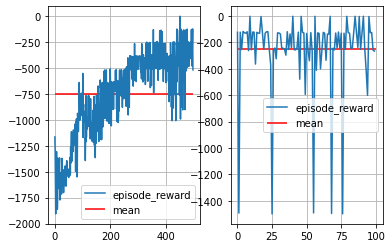

In [ ]:
#plot 1:
plt.subplot(1, 2, 1)
plt.plot(ddpg_hist_fit.history['episode_reward'])
plt.hlines(np.mean(ddpg_hist_fit.history['episode_reward']),0,len(ddpg_hist_fit.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])


#plot 2:
plt.subplot(1, 2, 2)
plt.plot(ddpg_hist_test.history['episode_reward'])
plt.hlines(np.mean(ddpg_hist_test.history['episode_reward']),0,len(ddpg_hist_test.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])

Al principio de todo, nuestro agente está “en blanco”, es decir, no sabe nada de nada de lo que tiene que hacer ni de cómo comportarse. Entonces podemos pensar en que tomará una de las posibles acciones aleatoriamente. E irá recibiendo pistas de si lo está haciendo bien ó mal en base a las recompensas. Entonces irá “tomando nota”, esto bien, esto mal.

Una recompensa para un humano es algún estímulo que le de placer. Podría ser un aumento de sueldo, chocolate, una buena noticia. Para nuestro modelo de ML la recompensa es sencillamente un Score: un valor numérico.

Supongamos que la acción “A” nos recompensa con 100 puntos. El Agente podría pensar “genial, voy a elegir A nuevamente para obtener 100 puntos” y puede que el algoritmo se estanque en una única acción y nunca logre concretar el objetivo global que queremos lograr.

Es decir que tenemos que lograr un equilibrio entre “explorar lo desconocido y explotar los recursos” en el ambiente. Eso es conocido como el dilema de exploración/explotación.

El agente explorará el ambiente e irá aprendiendo “cómo moverse” y cómo ganar recompensas (y evitar las penalizaciones). Al final almacenará el conocimiento en unas normas también llamadas “políticas“.

Pero… debo decir que es probable que el agente “muera” ó pierda la partida las primeras… ¿mil veces? Con esto me refiero a que deberemos entrenar miles y miles de veces al agente para que cometa errores y aciertos y pueda crear sus políticas hasta ser un buen Agente.

Si la recompensa es positiva estaremos reforzando ese comportamiento para el futuro. En cambio si la recompensa es negativa lo estaremos penalizando, para que ante la misma situación el agente actúe de manera distinta. El esquema en el que se apoya el Reinforcement Learning es en el de Proceso de Decisión de Markov.


Como podemos ver en la primera gráfica, tenemos el reward (ganancia), este valor se obtiene por episodio mientras entrena. Podemos ver que al principio se penalizaba en unos valores de -20000 aumentando linealmente a -250. Los valores no son muy buenos y nos indica que nuestro modelo no es el mejor. La segunda gráfica nos esta indicando que la media de penalizaiones, está se encuentra de media en -200. 

## NAF

https://keras-rl.readthedocs.io/en/latest/agents/naf/

In [ ]:
# NAF
#tf.compat.v1.enable_eager_execution()

tf.compat.v1.experimental.output_all_intermediates(
    state=True
)
class PendulumProcessor(Processor):
    def process_reward(self, reward):
        # The magnitude of the reward can be important. Since each step yields a relatively
        # high reward, we reduce the magnitude by two orders.
        return reward / 100.


ENV_NAME = 'Pendulum-v0'


# Get the environment and extract the number of actions.
env = gym.make(ENV_NAME)
np.random.seed(123)
env.seed(123)
assert len(env.action_space.shape) == 1
nb_actions = env.action_space.shape[0]

# Build all necessary models: V, mu, and L networks.
V_model = Sequential()
V_model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
V_model.add(Dense(16))
V_model.add(Activation('relu'))
V_model.add(Dense(16))
V_model.add(Activation('relu'))
V_model.add(Dense(16))
V_model.add(Activation('relu'))
V_model.add(Dense(1))
V_model.add(Activation('linear'))
print(V_model.summary())

mu_model = Sequential()
mu_model.add(Flatten(input_shape=(1,) + env.observation_space.shape))
mu_model.add(Dense(16))
mu_model.add(Activation('relu'))
mu_model.add(Dense(16))
mu_model.add(Activation('relu'))
mu_model.add(Dense(16))
mu_model.add(Activation('relu'))
mu_model.add(Dense(nb_actions))
mu_model.add(Activation('linear'))
print(mu_model.summary())

action_input = Input(shape=(nb_actions,), name='action_input')
observation_input = Input(shape=(1,) + env.observation_space.shape, name='observation_input')
x = Concatenate()([action_input, Flatten()(observation_input)])
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(32)(x)
x = Activation('relu')(x)
x = Dense(((nb_actions * nb_actions + nb_actions) // 2))(x)
x = Activation('linear')(x)
L_model = Model(inputs=[action_input, observation_input], outputs=x)
print(L_model.summary())

# Finally, we configure and compile our agent. You can use every built-in Keras optimizer and
# even the metrics!
processor = PendulumProcessor()
memory = SequentialMemory(limit=100000, window_length=1)
random_process = OrnsteinUhlenbeckProcess(theta=.15, mu=0., sigma=.3, size=nb_actions)
agent = NAFAgent(nb_actions=nb_actions, V_model=V_model, L_model=L_model, mu_model=mu_model,
                 memory=memory, nb_steps_warmup=100, random_process=random_process,
                 gamma=.99, target_model_update=1e-3, processor=processor)


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 3)                 0         
                                                                 
 dense_8 (Dense)             (None, 16)                64        
                                                                 
 activation_8 (Activation)   (None, 16)                0         
                                                                 
 dense_9 (Dense)             (None, 16)                272       
                                                                 
 activation_9 (Activation)   (None, 16)                0         
                                                                 
 dense_10 (Dense)            (None, 16)                272       
                                                                 
 activation_10 (Activation)  (None, 16)               

In [ ]:
agent.compile(Adam(lr=.001, clipnorm=1.), metrics=['mae'])

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [ ]:
# Entrenamiento
naf_hist_fit = agent.fit(env, nb_steps=100000, visualize=False, verbose=1, nb_max_episode_steps=200)
agent.save_weights('cdqn_{}_weights.h5f'.format(ENV_NAME), overwrite=True)

Training for 100000 steps ...
Interval 1 (0 steps performed)
    1/10000 [..............................] - ETA: 27:27 - reward: -0.0171

/usr/local/lib/python3.7/dist-packages/keras/engine/training_v1.py:2079: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


10000/10000 [==============================] - 444s 44ms/step - reward: -0.0747
50 episodes - episode_reward: -14.938 [-17.255, -10.595] - loss: 0.001 - mae: 0.016 - mean_q: 0.254

Interval 2 (10000 steps performed)
10000/10000 [==============================] - 432s 43ms/step - reward: -0.0775
50 episodes - episode_reward: -15.499 [-16.561, -12.145] - loss: 0.001 - mae: 0.019 - mean_q: -0.344

Interval 3 (20000 steps performed)
10000/10000 [==============================] - 432s 43ms/step - reward: -0.0773
50 episodes - episode_reward: -15.451 [-16.575, -9.932] - loss: 0.003 - mae: 0.028 - mean_q: -0.976

Interval 4 (30000 steps performed)
10000/10000 [==============================] - 443s 44ms/step - reward: -0.0794
50 episodes - episode_reward: -15.875 [-16.583, -13.754] - loss: 0.006 - mae: 0.032 - mean_q: -1.521

Interval 5 (40000 steps performed)
10000/10000 [==============================] - 442s 44ms/step - reward: -0.0792
50 episodes - episode_reward: -15.838 [-16.586, -14.86

In [ ]:
# Evaluación
naf_hist_test = agent.test(env, nb_episodes=100, visualize=False, nb_max_episode_steps=200)

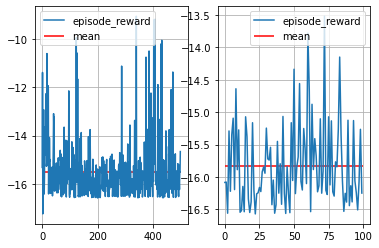

In [ ]:
#plot 1:
plt.subplot(1, 2, 1)
plt.plot(naf_hist_fit.history['episode_reward'])
plt.hlines(np.mean(naf_hist_fit.history['episode_reward']),0,len(naf_hist_fit.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])

#plot 2:
plt.subplot(1, 2, 2)
plt.plot(naf_hist_test.history['episode_reward'])
plt.hlines(np.mean(naf_hist_test.history['episode_reward']),0,len(naf_hist_test.history['episode_reward']),colors='r')
plt.grid()
plt.legend(["episode_reward", 'mean'])

Estas gráficas parecen que nos indican que nuestro modelo ha aprendido mejor aunque estos valores tampoco son para tirar cohetes. Los valores isguen siendo negativos y nis interesa maximizar nuestras ganancias. 

Text(0.5, 1.0, 'DDPG vs NAF - Training')

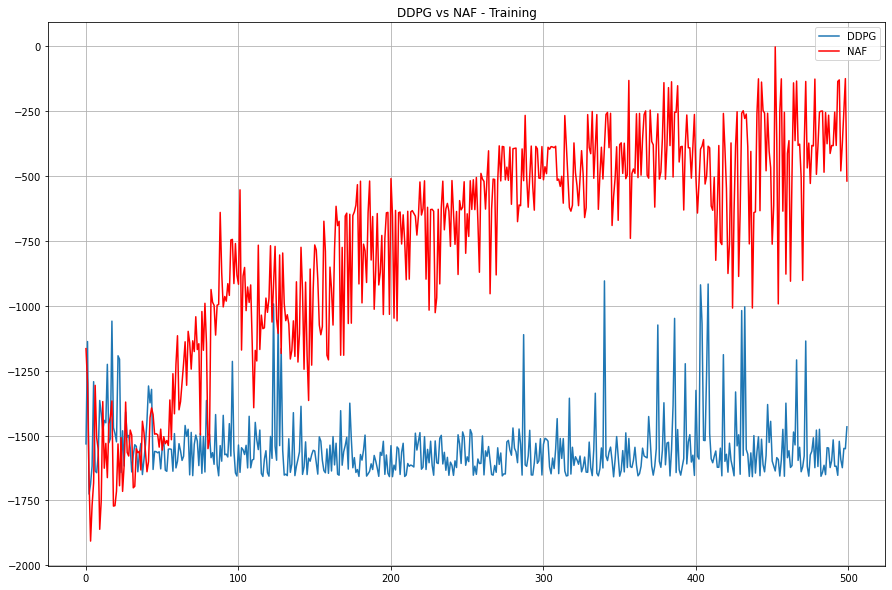

In [ ]:
# Visualizo la comparativa de ambos algoritmos
# NAF utiliza un procesador de reward que divide el rewar entre 100.
#  Para compararlo con DDPG es necesario volver a multiplicarlo por 100 para ajustarlo
plt.figure(figsize=(15,10))
plt.plot(np.array(naf_hist_fit.history['episode_reward'])*100)
plt.plot(ddpg_hist_fit.history['episode_reward'], c='r')
plt.grid()
plt.legend(["DDPG", 'NAF'])
plt.title('DDPG vs NAF - Training')

Text(0.5, 1.0, 'DDPG vs NAF - Training')

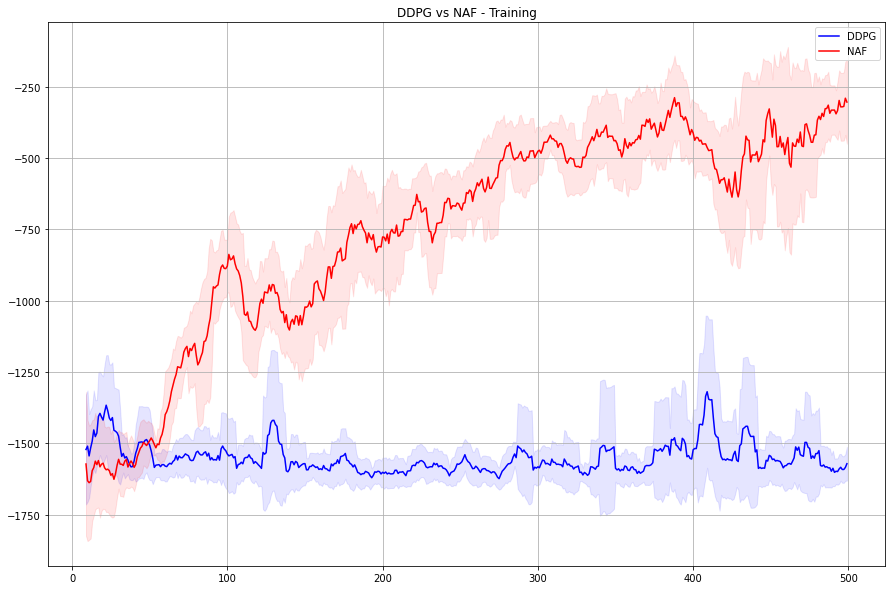

In [ ]:
# En lugar de plotear la gráfica en bruto, saco una media móvil y su desviación estandard
window = 10
plt.figure(figsize=(15,10))
naf_serie = pd.Series(np.array(naf_hist_fit.history['episode_reward'])*100)
ddpg_serie = pd.Series(ddpg_hist_fit.history['episode_reward'])
plt.plot(naf_serie.rolling(window).mean(), c='b')
plt.fill_between(naf_serie.index,
                     naf_serie.rolling(window).mean() - naf_serie.rolling(window).std(),
                     naf_serie.rolling(window).mean() + naf_serie.rolling(window).std(),
                     color='b',
                     alpha=0.1)
plt.plot(ddpg_serie.rolling(window).mean(), c='r')
plt.fill_between(ddpg_serie.index,
                     ddpg_serie.rolling(window).mean() - ddpg_serie.rolling(window).std(),
                     ddpg_serie.rolling(window).mean() + ddpg_serie.rolling(window).std(),
                     color='r',
                     alpha=0.1)
plt.grid()
plt.legend(["DDPG", 'NAF'])
plt.title('DDPG vs NAF - Training')

## Conclusión 

Lo que estamos viendo en las gráficas es lo que ocurre con nuesto modelo. Primero entrenamos nuesto modelo con información que tenemos (gráficas dobles la de la izquierda). Luego, el modelo se comprueba con el péndulo (algoritmo que lo que intenta es que el palo se quede arriba del todo girando), este paso es la gráficas dobles la de la derecha. 

Podemos observar que en ambos modelos las penalizaciones disminuyen linealmente en un rango de [-1750:-250]. Los valores son bastantes negativos ya que nuestro objetivo se encuentra en maximizar la ganancia

Estas gráficas lo que nos muestran es que a nuestro modelo se le está penalizando continuamente, por lo que nuestro modelo no está aprendiendo nada.

Si comparamos la forma de trabajar de los dos agentes utilizados (DDPG vs NAF). En este caso la ejecución en NAF es bastante mejor aunque tiene como debilidad que el tiempod e ejecución es bastante mayor al tiempo de ejecución de DDPG. Este entorno del agente es mil veces más lento.

En DDPG se obtuvo un entorno de ejecución de 1495.041 segundos, lo que se convierte a ser 24.9173 minutos. En NAF tenemos un entorno de ejecución de 4405.456 segundos lo que es igual a 1 hora y 13.422 minutos.


## Ejercicios EXTRA

4) Prueba un algoritmo de Deep Reinforcement Learning diferente.

https://colab.research.google.com/github/Hvass-Labs/TensorFlow-Tutorials/blob/master/16_Reinforcement_Learning.ipynb

5) Resuelve el entorno "cartpole".


6) Resuelve el entorno "cartpole" con otro framework y compara los resultados.

https://colab.research.google.com/github/takuseno/d3rlpy/blob/master/tutorials/cartpole.ipynb